<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/keras_tuner_ann_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Choosing hyperparameters for your ANN

How do you decide on how many hidden layers to use, how many nodes each layer should have, or what loss function to use?

KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that helps conduct a hyperparameter search for your specific problem.

Docs: https://keras.io/keras_tuner/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import sklearn
from sklearn.preprocessing import MinMaxScaler
import keras
from keras import layers

In [2]:
# keras-tuner doesn't come installed in colab so lets install
!pip install keras-tuner -q

In [3]:
import keras_tuner

Similar to our first ann notebook, we will create some toy data to play with.

In [4]:
np.random.seed(123)

# set the time range from 1999-2019
times = pd.date_range("1999-01-01", "2019-12-31", name="time")

# create an "annual cycle"
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

# create some base "temperatures"
base = 10 + 15 * annual_cycle.reshape(-1, 1)
tmin_values = base + 3 * np.random.randn(annual_cycle.size, 1)
tmax_values = base + 10 + 3 * np.random.randn(annual_cycle.size, 1)

# let's put these dummy temperatures into an xarray dataset
ds = xr.Dataset(
    {
        "tmin": (("time", "location"), tmin_values),
        "tmax": (("time", "location"), tmax_values),
    },
    {"time": times, "location": ["IA"]},
)

In [5]:
# lets split our data into train/test sets using dates
train = ds.sel(time=slice('1999-01-01T00:00:00.000000000','2014-12-31T00:00:00.000000000'))
test = ds.sel(time=slice('2015-01-01T00:00:00.000000000','2019-12-31T00:00:00.000000000'))

# and grab the input feature and labels
input_train = train.tmin
label_train = train.tmax

In [6]:
# create our scaler object
scaler_input = MinMaxScaler()
scaler_label = MinMaxScaler()

# fit it to our training set
scaler_input.fit(input_train)
scaler_label.fit(label_train)

# now transform our input data and labels
input_train_scaled = scaler_input.transform(input_train)
label_train_scaled = scaler_label.transform(label_train)

### Searching hyperparameters

To start our hyperparameter search, we will build our ANN sequentially, as we did in the first ann notebook. However, we will place this model into a function call build_model(hp). hp will be our hyperparameter object used during the search. Additionally, we will use hyperparameter objects with predefined ranges and sampling/steps, depending on what we want to explore.

In [7]:
def build_model(hp):
    # start building model
    model = keras.Sequential()
    # input layer stays the same as before
    model.add(keras.Input(shape=(1,), name="input_layer"))
    # instead of choosing the number of nodes, we add an hp object
    hp_units_1 = hp.Int('units_1', min_value=2, max_value=12, step=1)
    hp_units_2 = hp.Int('units_2', min_value=2, max_value=12, step=1)
    model.add(
        keras.layers.Dense(
            units=hp_units_1,
            activation=keras.activations.relu
            )
        )
    model.add(
        keras.layers.Dense(
            units=hp_units_2,
            activation=keras.activations.relu
            )
        )
    # likewise, we will search for the learning rate
    learning_rate = hp.Float(
        "lr", min_value=1e-4, max_value=1e-2, sampling="log"
        )
    model.compile(
        keras.optimizers.SGD(learning_rate=learning_rate),
        loss='mse'
        )
    return model

hyperparameter method options include: https://keras.io/api/keras_tuner/hyperparameters/

In [12]:
build_model(keras_tuner.HyperParameters())

Next up, we initialize a tuner.

Here we use RandomSearch (https://keras.io/api/keras_tuner/tuners/random/), but you can also use a Bayesian option (https://keras.io/api/keras_tuner/tuners/bayesian/).

We use objective to specify the objective to select the best models, which in our case we base it on the validation set loss. We then use max_trials to specify the number of different models to try.

In [13]:
#tuner = keras_tuner.RandomSearch(
#    hypermodel=build_model,
#    objective="val_loss",
#    max_trials=100,
#    seed=123,
#    overwrite=True
#)

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=100,
    num_initial_points=50,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    # hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    overwrite=True
)

You can print a summary of the search space:

In [14]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 12, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 12, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


Make sure input and label data are ready for training...

In [15]:
input_train_scaled.reshape(1,-1).squeeze().shape

(5844,)

In [16]:
label_train_scaled.reshape(1,-1).squeeze().shape

(5844,)

Now start the hyperparameter search! Here we set the first 5000 samples for training and the remaining samples as the validation set.

In [17]:
tuner.search(
    input_train_scaled.reshape(1,-1).squeeze()[:5000],
    label_train_scaled.reshape(1,-1).squeeze()[:5000],
    epochs=20,
    validation_data=(
        input_train_scaled.reshape(1,-1).squeeze()[5000:],
        label_train_scaled.reshape(1,-1).squeeze()[5000:])
    )

Trial 100 Complete [00h 00m 09s]
val_loss: 0.22613386809825897

Best val_loss So Far: 0.008198599331080914
Total elapsed time: 00h 16m 47s


# Querying the results

When hyperparameter search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_loss because we set that as the objective.

In [18]:
# we can now query the tuner object and grab the best models
# here we grab the best two models
models = tuner.get_best_models(num_models=2)

In [19]:
models

In [20]:
# here is the best model
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 18        
                                                                 
 dense_1 (Dense)             (None, 2)                 20        
                                                                 
Total params: 38 (152.00 Byte)
Trainable params: 38 (152.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# here is the second best model
best_model = models[1]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 34 (136.00 Byte)
Trainable params: 34 (136.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can also print a summary of the search results.

In [22]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 057 summary
Hyperparameters:
units_1: 9
units_2: 2
lr: 0.004401768822986867
Score: 0.008198599331080914

Trial 064 summary
Hyperparameters:
units_1: 8
units_2: 2
lr: 0.0012655560244433175
Score: 0.009423202835023403

Trial 022 summary
Hyperparameters:
units_1: 7
units_2: 2
lr: 0.003298757461307946
Score: 0.010363856330513954

Trial 065 summary
Hyperparameters:
units_1: 5
units_2: 5
lr: 0.00703649382753033
Score: 0.010851570405066013

Trial 077 summary
Hyperparameters:
units_1: 7
units_2: 2
lr: 0.003425133066484979
Score: 0.012281861156225204

Trial 005 summary
Hyperparameters:
units_1: 4
units_2: 2
lr: 0.0034928656354620575
Score: 0.012883968651294708

Trial 012 summary
Hyperparameters:
units_1: 6
units_2: 3
lr: 0.0010874771484415556
Score: 0.014009159989655018

Trial 009 summary
Hyperparameters:
units_1: 11
units_2: 9
lr: 0.009022079415210089
Score: 0.049138378351926

### Retrain the model

Keras-tuner also makes it easy to retrain a model using the set of hyperparameters that performed well.
If you want to train the model with the entire dataset, you may retrieve the best hyperparameters and retrain the model by yourself.

In [23]:
# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=1)

In [24]:
best_hps

In [25]:
# Build the model with the best hp.
model = build_model(best_hps[0])

In [26]:
# now train!
history = model.fit(
    x=input_train_scaled.reshape(1,-1).squeeze(),
    y=label_train_scaled.reshape(1,-1).squeeze(),
    epochs=20,
    validation_split=0.1,
    batch_size=32
    )

Epoch 1/20
165/165 [==============================] - 1s 3ms/step - loss: 0.1673 - val_loss: 0.1775
Epoch 2/20
165/165 [==============================] - 0s 2ms/step - loss: 0.1589 - val_loss: 0.1760
Epoch 3/20
165/165 [==============================] - 0s 2ms/step - loss: 0.1584 - val_loss: 0.1757
Epoch 4/20
165/165 [==============================] - 0s 2ms/step - loss: 0.1583 - val_loss: 0.1755
Epoch 5/20
165/165 [==============================] - 0s 2ms/step - loss: 0.1582 - val_loss: 0.1754
Epoch 6/20
165/165 [==============================] - 0s 2ms/step - loss: 0.1581 - val_loss: 0.1753
Epoch 7/20
165/165 [==============================] - 0s 2ms/step - loss: 0.1580 - val_loss: 0.1753
Epoch 8/20
165/165 [==============================] - 0s 2ms/step - loss: 0.1580 - val_loss: 0.1752
Epoch 9/20
165/165 [==============================] - 0s 2ms/step - loss: 0.1579 - val_loss: 0.1751
Epoch 10/20
165/165 [==============================] - 0s 2ms/step - loss: 0.1579 - val_loss: 0.1751

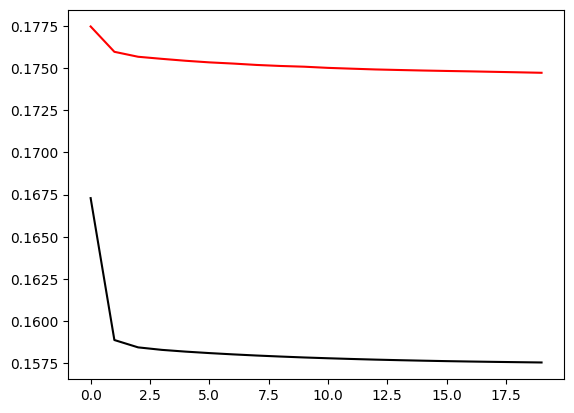

In [27]:
plt.plot(range(0,20), history.history['loss'], c='k')
plt.plot(range(0,20), history.history['val_loss'], c='r')
plt.show()

Seems like our results can vary depending on the validation set we "hold out." Ensuring that our ANN is robust to subsets of our data distribution necessitates k-fold cross-validation. Read here for how to use sklearn cross validation utilities with keras models: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md